In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# End-to-End

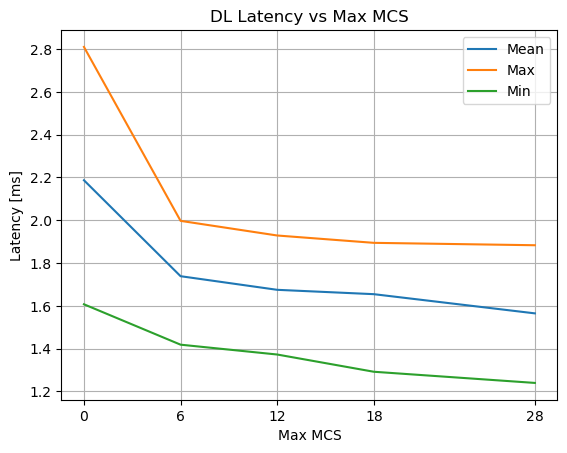

In [3]:
mcs = [0, 6, 12, 18, 28]

means = []
mins = []
maxs = []

for i in mcs:
    df = pd.read_csv(f"mcs-test/e2e-mcs-{i}.csv")
    quant = df["time"].quantile(0.95)
    mean = df[df["time"] < quant]["time"].mean()*1000
    mini = df[df["time"] < quant]["time"].min()*1000
    maxi = df[df["time"] < quant]["time"].max()*1000

    means.append(mean)
    mins.append(mini)
    maxs.append(maxi)
    
plt.plot(mcs, means, label="Mean")
plt.plot(mcs, maxs, label="Max")
plt.plot(mcs, mins, label="Min")
plt.grid()
plt.xlabel("Max MCS")
plt.ylabel("Latency [ms]")
plt.xticks(mcs)
plt.title("DL Latency vs Max MCS")
plt.legend()
plt.savefig("latency-vs-mcs.png")
plt.show()

# Protocol Latency

In [5]:
sizes = [1024]
means_2 = []
mins = []
maxs = []

rlc = []
sdap = []
pdcp = []

for i in mcs:
    print(f"Max MCS: {i}")
    df = pd.read_csv(f"mcs-test/pl-mcs-{i}.csv")
    df = df.sort_values(by="time")
    df = df.dropna().reset_index()

    times = df["time"].unique()
    values = [times[0]]
    
    for time in times:
        add = True
        for value in values:
            if abs(value-time) < 50000:
                add = False
        if add:
            values.append(time)

    print(f"Total number of packets: {len(values)}")

    shapes = []
    times = {}
    function_calls = {}
    sdap_total_calls = []
    mean_time = []

    for module in df["module"].unique():
        times[module] = {}
        for time in sizes:
            times[module][time] = []
        function_calls[module] = []

    for time in values:
        df_temp = df[df["time"] >= time][df["time"] < time+50000]
        df_temp = df_temp.sort_values(by="time")
        
        shapes.append(df_temp[df_temp["timing"] == "start"].shape[0])
        sdap_calls = df_temp[df_temp["function"] == "sdap_data_req"][df_temp["timing"] == "start"].shape[0]
        sdap_total_calls.append(sdap_calls)
        end_time = df_temp["time"].max()
        
        total_time = df_temp["time"].max()-df_temp["time"].min()
        mean_time.append(total_time)
        
        
          ## Create Temp Dict
        protocol_time = {}
        for module in df_temp["module"].unique():        
            calls = df_temp[df_temp["module"] == module][df_temp["timing"] == "start"].shape[0]
            function_calls[module].append(calls)
            protocol_time[module] = 0
            
        start = df_temp.reset_index()
        for ind in start.index[:-1]:
            curr_time = start["time"][ind]
            next_time = start["time"][ind+1]
            time = next_time - curr_time

            if start["function"][ind+1] == "start":
                module = start["module"][ind]
            else:
                module = start["module"][ind+1]
            protocol_time[module] += time
    
        ## Add Times to Final Dict
        temp = 0 
        for i in protocol_time:
            temp += protocol_time[i]
            times[i][sizes[0]].append(protocol_time[i])
    
    new_time = np.array(mean_time)
    mask = new_time < np.quantile(mean_time, 0.95)
    new_mean_time = new_time[mask]
    
    rlc_temp = np.array(times["[RLC]"][1024])[mask]
    rlc.append(np.mean(rlc_temp)/1000)
    
    pdcp_temp = np.array(times["[PDCP]"][1024])[mask]
    pdcp.append(np.mean(pdcp_temp)/1000)
    
    sdap_temp = np.array(times["[SDAP]"][1024])[mask]
    sdap.append(np.mean(sdap_temp)/1000)
    
    means_2.append(np.mean(new_mean_time)/1000)
    maxs.append(np.max(new_mean_time)/1000)
    mins.append(np.min(new_mean_time)/1000)

Max MCS: 0
Total number of packets: 100
Max MCS: 6
Total number of packets: 100
Max MCS: 12
Total number of packets: 100
Max MCS: 18
Total number of packets: 100
Max MCS: 28
Total number of packets: 100


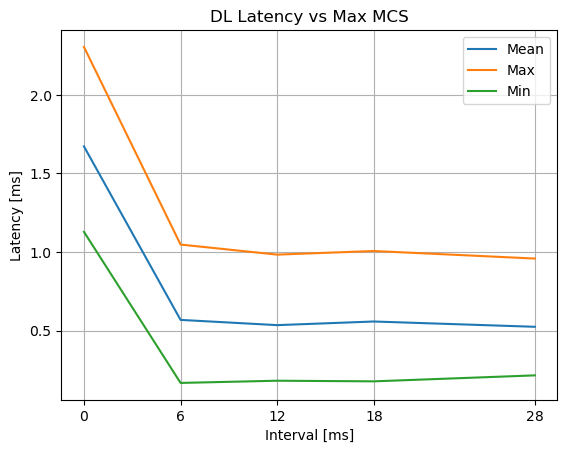

In [6]:
plt.plot(mcs, means_2, label="Mean")
plt.plot(mcs, maxs, label="Max")
plt.plot(mcs, mins, label="Min")
plt.grid()
plt.xlabel("Interval [ms]")
plt.ylabel("Latency [ms]")
plt.xticks(mcs)
plt.title("DL Latency vs Max MCS")
plt.legend()
plt.show()

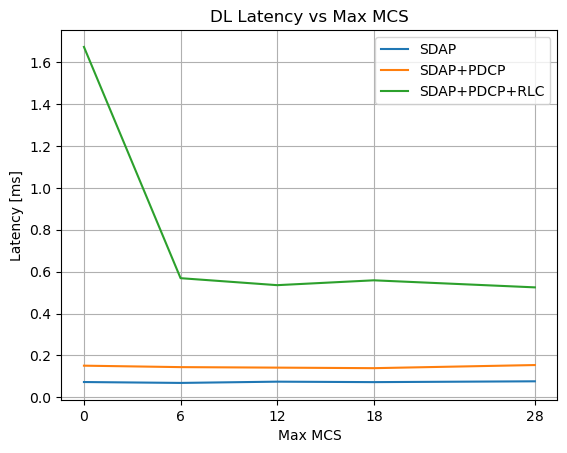

In [8]:
rlc = np.array(rlc)
sdap = np.array(sdap)
pdpc = np.array(pdcp)

plt.plot(mcs, sdap, label="SDAP")
plt.plot(mcs, sdap+pdcp, label="SDAP+PDCP")
plt.plot(mcs, sdap+pdcp+rlc, label="SDAP+PDCP+RLC")
#plt.plot(mcs, means, label="End-to-End")

plt.grid()
plt.xlabel("Max MCS")
plt.ylabel("Latency [ms]")
plt.xticks(mcs)
plt.title("DL Latency vs Max MCS")
plt.legend()
plt.savefig("pl_latency-vs-mcs.png")
plt.show()